In [3]:
# 构建语料库，每行包含中文、英文（解码器输入）和翻译成英文后的目标输出 3 个句子
sentences = [
    ['咖哥 喜欢 小冰', '<sos> KaGe likes XiaoBing', 'KaGe likes XiaoBing <eos>'],
    ['我 爱 学习 人工智能', '<sos> I love studying AI', 'I love studying AI <eos>'],
    ['深度学习 改变 世界', '<sos> Deep Learning changed the world', 'Deep Learning changed the world <eos>'],
    ['自然 语言 处理 很 强大', '<sos> Natural Language Processing is powerful', 'Natural Language Processing is powerful <eos>'],
    ['神经网络 非常 复杂', '<sos> Neural Networks are complex', 'Neural Networks are complex <eos>']]
word_list_cn, word_list_en = [], []  # 初始化中英文词汇表
# 遍历每一个句子并将单词添加到词汇表中
for s in sentences:
    word_list_cn.extend(s[0].split())
    word_list_en.extend(s[1].split())
    word_list_en.extend(s[2].split())
# 去重，得到没有重复单词的词汇表
word_list_cn = list(set(word_list_cn))
word_list_en = list(set(word_list_en))
# 构建单词到索引的映射
word2idx_cn = {w: i for i, w in enumerate(word_list_cn)}
word2idx_en = {w: i for i, w in enumerate(word_list_en)}
# 构建索引到单词的映射
idx2word_cn = {i: w for i, w in enumerate(word_list_cn)}
idx2word_en = {i: w for i, w in enumerate(word_list_en)}
# 计算词汇表的大小
voc_size_cn = len(word_list_cn)
voc_size_en = len(word_list_en)
print(" 句子数量：", len(sentences)) # 打印句子数
print(" 中文词汇表大小：", voc_size_cn) # 打印中文词汇表大小
print(" 英文词汇表大小：", voc_size_en) # 打印英文词汇表大小
print(" 中文词汇到索引的字典：", word2idx_cn) # 打印中文词汇到索引的字典
print(" 英文词汇到索引的字典：", word2idx_en) # 打印英文词汇到索引的字典

 句子数量： 5
 中文词汇表大小： 18
 英文词汇表大小： 23
 中文词汇到索引的字典： {'爱': 0, '我': 1, '深度学习': 2, '改变': 3, '语言': 4, '自然': 5, '强大': 6, '非常': 7, '咖哥': 8, '很': 9, '复杂': 10, '喜欢': 11, '人工智能': 12, '处理': 13, '小冰': 14, '神经网络': 15, '学习': 16, '世界': 17}
 英文词汇到索引的字典： {'love': 0, 'XiaoBing': 1, 'changed': 2, 'complex': 3, 'world': 4, 'the': 5, 'are': 6, 'Deep': 7, 'I': 8, 'Networks': 9, 'Processing': 10, 'KaGe': 11, 'Neural': 12, 'Learning': 13, 'Language': 14, '<eos>': 15, '<sos>': 16, 'Natural': 17, 'AI': 18, 'powerful': 19, 'studying': 20, 'is': 21, 'likes': 22}


In [4]:
import numpy as np # 导入 numpy
import torch # 导入 torch
import random # 导入 random 库
# 定义一个函数，随机选择一个句子和词汇表生成输入、输出和目标数据
def make_data(sentences):
    # 随机选择一个句子进行训练
    random_sentence = random.choice(sentences)
    # 将输入句子中的单词转换为对应的索引
    encoder_input = np.array([[word2idx_cn[n] for n in random_sentence[0].split()]])
    # 将输出句子中的单词转换为对应的索引
    decoder_input = np.array([[word2idx_en[n] for n in random_sentence[1].split()]])
    # 将目标句子中的单词转换为对应的索引
    target = np.array([[word2idx_en[n] for n in random_sentence[2].split()]])
    # 将输入、输出和目标批次转换为 LongTensor
    encoder_input = torch.LongTensor(encoder_input)
    decoder_input = torch.LongTensor(decoder_input)
    target = torch.LongTensor(target)
    return encoder_input, decoder_input, target 
# 使用 make_data 函数生成输入、输出和目标张量
encoder_input, decoder_input, target = make_data(sentences)
for s in sentences: # 获取原始句子
    if all([word2idx_cn[w] in encoder_input[0] for w in s[0].split()]):
        original_sentence = s
        break
print(" 原始句子：", original_sentence) # 打印原始句子
print(" 编码器输入张量的形状：", encoder_input.shape)  # 打印输入张量形状
print(" 解码器输入张量的形状：", decoder_input.shape) # 打印输出张量形状
print(" 目标张量的形状：", target.shape) # 打印目标张量形状
print(" 编码器输入张量：", encoder_input) # 打印输入张量
print(" 解码器输入张量：", decoder_input) # 打印输出张量
print(" 目标张量：", target) # 打印目标张量

 原始句子： ['我 爱 学习 人工智能', '<sos> I love studying AI', 'I love studying AI <eos>']
 编码器输入张量的形状： torch.Size([1, 4])
 解码器输入张量的形状： torch.Size([1, 5])
 目标张量的形状： torch.Size([1, 5])
 编码器输入张量： tensor([[ 1,  0, 16, 12]])
 解码器输入张量： tensor([[16,  8,  0, 20, 18]])
 目标张量： tensor([[ 8,  0, 20, 18, 15]])


In [5]:
# 定义 Attention 类
import torch.nn as nn # 导入 torch.nn 库
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
    def forward(self, decoder_context, encoder_context):
        # 计算 decoder_context 和 encoder_context 的点积，得到注意力分数
        scores = torch.matmul(decoder_context, encoder_context.transpose(-2, -1))
        # 归一化分数
        attn_weights = nn.functional.softmax(scores, dim=-1)
        # 将注意力权重乘以 encoder_context，得到加权的上下文向量
        context = torch.matmul(attn_weights, encoder_context)
        return context, attn_weights

In [6]:
import torch.nn as nn # 导入 torch.nn 库
# 定义编码器类
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()       
        self.hidden_size = hidden_size # 设置隐藏层大小       
        self.embedding = nn.Embedding(input_size, hidden_size) # 创建词嵌入层       
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True) # 创建 RNN 层    
    def forward(self, inputs, hidden): # 前向传播函数
        embedded = self.embedding(inputs) # 将输入转换为嵌入向量       
        output, hidden = self.rnn(embedded, hidden) # 将嵌入向量输入 RNN 层并获取输出
        return output, hidden
# 定义解码器类
class DecoderWithAttention(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderWithAttention, self).__init__()
        self.hidden_size = hidden_size # 设置隐藏层大小
        self.embedding = nn.Embedding(output_size, hidden_size) # 创建词嵌入层
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True) # 创建 RNN 层
        self.attention = Attention()  # 创建注意力层
        self.out = nn.Linear(2 * hidden_size, output_size)  # 修改线性输出层，考虑隐藏状态和上下文向量
    def forward(self, dec_input, hidden, enc_output):
        embedded = self.embedding(dec_input)  # 将输入转换为嵌入向量
        rnn_output, hidden = self.rnn(embedded, hidden)  # 将嵌入向量输入 RNN 层并获取输出 
        context, attn_weights = self.attention(rnn_output, enc_output)  # 计算注意力上下文向量
        dec_output = torch.cat((rnn_output, context), dim=-1)  # 将上下文向量与解码器的输出拼接
        dec_output = self.out(dec_output)  # 使用线性层生成最终输出
        return dec_output, hidden, attn_weights
n_hidden = 128 # 设置隐藏层数量
# 创建编码器和解码器
encoder = Encoder(voc_size_cn, n_hidden)
decoder = DecoderWithAttention(n_hidden, voc_size_en)
print(' 编码器结构：', encoder)  # 打印编码器的结构
print(' 解码器结构：', decoder)  # 打印解码器的结构

 编码器结构： Encoder(
  (embedding): Embedding(18, 128)
  (rnn): RNN(128, 128, batch_first=True)
)
 解码器结构： DecoderWithAttention(
  (embedding): Embedding(23, 128)
  (rnn): RNN(128, 128, batch_first=True)
  (attention): Attention()
  (out): Linear(in_features=256, out_features=23, bias=True)
)


In [8]:
# 定义 Seq2Seq 类
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        # 初始化编码器和解码器
        self.encoder = encoder
        self.decoder = decoder    
    def forward(self, encoder_input, hidden, decoder_input): 
        # 将输入序列通过编码器并获取输出和隐藏状态
        encoder_output, encoder_hidden = self.encoder(encoder_input, hidden)
        # 将编码器的隐藏状态传递给解码器作为初始隐藏状态
        decoder_hidden = encoder_hidden
        # 将目标序列通过解码器并获取输出 -  此处更新解码器调用
        decoder_output, _, attn_weights = self.decoder(decoder_input, decoder_hidden, encoder_output) 
        return decoder_output, attn_weights
# 创建 Seq2Seq 模型
model = Seq2Seq(encoder, decoder)
print('S2S 模型结构：', model)  # 打印模型的结构

S2S 模型结构： Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(18, 128)
    (rnn): RNN(128, 128, batch_first=True)
  )
  (decoder): DecoderWithAttention(
    (embedding): Embedding(23, 128)
    (rnn): RNN(128, 128, batch_first=True)
    (attention): Attention()
    (out): Linear(in_features=256, out_features=23, bias=True)
  )
)


In [9]:
# 定义训练函数
def train_seq2seq(model, criterion, optimizer, epochs):
    for epoch in range(epochs):
       encoder_input, decoder_input, target = make_data(sentences) # 训练数据的创建
       hidden = torch.zeros(1, encoder_input.size(0), n_hidden) # 初始化隐藏状态      
       optimizer.zero_grad()# 梯度清零        
       output, _ = model(encoder_input, hidden, decoder_input) # 获取模型输出         
       loss = criterion(output.view(-1, voc_size_en), target.view(-1)) # 计算损失        
       if (epoch + 1) % 40 == 0: # 打印损失
          print(f"Epoch: {epoch + 1:04d} cost = {loss:.6f}")         
       loss.backward()# 反向传播        
       optimizer.step()# 更新参数      
# 训练模型
epochs = 400 # 训练轮次
criterion = nn.CrossEntropyLoss() # 损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 优化器
train_seq2seq(model, criterion, optimizer, epochs) # 调用函数训练模型

Epoch: 0040 cost = 0.670532
Epoch: 0080 cost = 0.064800
Epoch: 0120 cost = 0.020992
Epoch: 0160 cost = 0.019317
Epoch: 0200 cost = 0.011486
Epoch: 0240 cost = 0.009124
Epoch: 0280 cost = 0.008484
Epoch: 0320 cost = 0.005958
Epoch: 0360 cost = 0.004367
Epoch: 0400 cost = 0.003501


In [11]:
import matplotlib.pyplot as plt # 导入 matplotlib
import seaborn as sns # 导入 seaborn
plt.rcParams["font.family"]=['SimHei'] # 用来设定字体样式
plt.rcParams['font.sans-serif']=['SimHei'] # 用来设定无衬线字体样式
plt.rcParams['axes.unicode_minus']=False #  用来正常显示负号 
def  visualize_attention(source_sentence, predicted_sentence, attn_weights):    
    plt.figure(figsize=(10, 10)) # 画布
    ax = sns.heatmap(attn_weights, annot=True, cbar=False, 
                     xticklabels=source_sentence.split(), 
                     yticklabels=predicted_sentence, cmap="Greens") # 热力图
    plt.xlabel(" 源序列 ") 
    plt.ylabel(" 目标序列 ")
    plt.show() # 显示图片

咖哥 喜欢 小冰 -> ['KaGe', 'XiaoBing', 'KaGe']


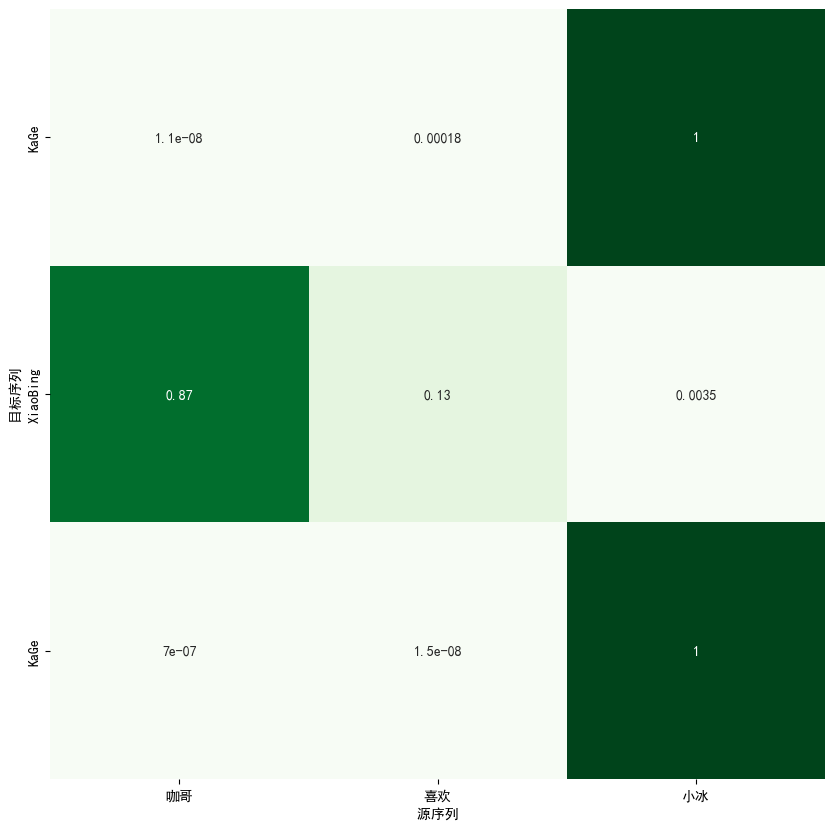

自然 语言 处理 很 强大 -> ['Natural', 'is', 'Processing', 'Language', 'Language']


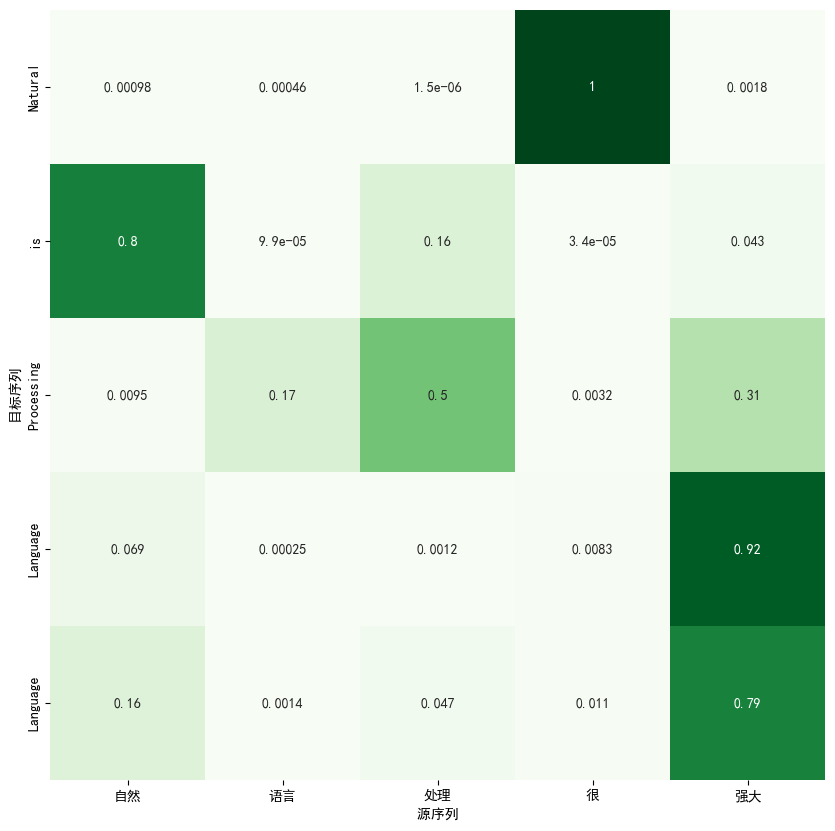

In [12]:
# 定义测试函数
def test_seq2seq(model, source_sentence):
    # 将输入的句子转换为索引
    encoder_input = np.array([[word2idx_cn[n] for n in source_sentence.split()]])
    # 构建输出的句子的索引，以 '<sos>' 开始，后面跟 '<eos>'，长度与输入句子相同
    decoder_input = np.array([word2idx_en['<sos>']] + [word2idx_en['<eos>']]*(len(encoder_input[0])-1))
    # 转换为 LongTensor 类型
    encoder_input = torch.LongTensor(encoder_input)
    decoder_input = torch.LongTensor(decoder_input).unsqueeze(0) # 增加一维    
    hidden = torch.zeros(1, encoder_input.size(0), n_hidden) # 初始化隐藏状态    
    # 获取模型输出和注意力权重
    predict, attn_weights = model(encoder_input, hidden, decoder_input)    
    predict = predict.data.max(2, keepdim=True)[1] # 获取概率最大的索引
    # 打印输入的句子和预测的句子
    print(source_sentence, '->', [idx2word_en[n.item()] for n in predict.squeeze()])
    # 可视化注意力权重
    attn_weights = attn_weights.squeeze(0).cpu().detach().numpy()
    visualize_attention(source_sentence, [idx2word_en[n.item()] for n in predict.squeeze()], attn_weights)    
# 测试模型
test_seq2seq(model, '咖哥 喜欢 小冰')  
test_seq2seq(model, '自然 语言 处理 很 强大')